In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
twitch_df = pd.read_csv("Twitch_game_data.csv", encoding='latin-1')
igdb_df = pd.read_csv("data.csv", encoding='UTF-8')

# Strip column names of whitespace
twitch_df.columns = twitch_df.columns.str.strip()
igdb_df.columns = igdb_df.columns.str.strip()

print("Twitch Data Columns:", twitch_df.columns)
print("IGDB Data Columns:", igdb_df.columns)

# Merge datasets on "Game"
merged_df = pd.merge(twitch_df, igdb_df, on='Game', how='left')

print("Before dropna, columns:", merged_df.columns)
print("Missing values:\n", merged_df.isna().sum())

# Handle duplicate columns from merging
for col in ['Rank', 'Avg_viewers', 'Hours_streamed', 'Peak_viewers', 'Streamers']:
    if col + "_x" in merged_df.columns and col + "_y" in merged_df.columns:
        merged_df[col] = merged_df[col + "_x"].fillna(merged_df[col + "_y"])
        merged_df.drop(columns=[col + "_x", col + "_y"], inplace=True)
    elif col + "_x" in merged_df.columns:
        merged_df.rename(columns={col + "_x": col}, inplace=True)
    elif col + "_y" in merged_df.columns:
        merged_df.rename(columns={col + "_y": col}, inplace=True)

# Ensure "Rank" column exists
if "Rank" not in merged_df.columns:
    raise KeyError("Missing 'Rank' column after merging.")

# Process "Release_Year" column
if "Release_Year" in merged_df.columns:
    merged_df["Release_Year"] = pd.to_numeric(merged_df["Release_Year"], errors="coerce")
    merged_df.dropna(subset=["Release_Year"], inplace=True)
    merged_df["Release_Year"] = merged_df["Release_Year"].astype(int)
else:
    raise KeyError("Missing 'Release_Year' in dataset.")

# Convert Rank into Classification Labels
def categorize_rank(rank):
    if rank <= 10:
        return "Top 10"
    elif rank <= 50:
        return "Top 50"
    elif rank <= 100:
        return "Top 100"
    elif rank <= 200:
        return "Top 200"
    else:
        return "Other"  # Optional for ranks above 200

merged_df["Rank_Category"] = merged_df["Rank"].apply(categorize_rank)
merged_df["Rank_Category"] = pd.Categorical(merged_df["Rank_Category"])

# One-hot encoding for Genre
if "Genre" in merged_df.columns:
    merged_df = pd.get_dummies(merged_df, columns=["Genre"], dummy_na=True)

# Define features and target
features = ["Avg_viewers", "Hours_streamed", "Peak_viewers", "Streamers"] \
           + [col for col in merged_df.columns if col.startswith("Genre_")]

target = "Rank_Category"

# Check for missing columns in features
missing_cols = set(features) - set(merged_df.columns)
if missing_cols:
    raise KeyError(f"Missing columns in dataset: {missing_cols}")

X = merged_df[features]
y = merged_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predictions
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Model Evaluation
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nRandom Forest Classification Model Performance:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))




Twitch Data Columns: Index(['Rank', 'Game', 'Month', 'Year', 'Hours_watched', 'Hours_streamed',
       'Peak_viewers', 'Peak_channels', 'Streamers', 'Avg_viewers',
       'Avg_channels', 'Avg_viewer_ratio'],
      dtype='object')
IGDB Data Columns: Index(['Rank', 'Game', 'Month', 'Year', 'Hours_watched', 'Hours_streamed',
       'Peak_viewers', 'Peak_channels', 'Streamers', 'Avg_viewers',
       'Avg_channels', 'Avg_viewer_ratio', 'Genre', 'Release_Year',
       'Release_Month', 'New_Game', 'Wrong', 'rank_category'],
      dtype='object')
Before dropna, columns: Index(['Rank_x', 'Game', 'Month_x', 'Year_x', 'Hours_watched_x',
       'Hours_streamed_x', 'Peak_viewers_x', 'Peak_channels_x', 'Streamers_x',
       'Avg_viewers_x', 'Avg_channels_x', 'Avg_viewer_ratio_x', 'Rank_y',
       'Month_y', 'Year_y', 'Hours_watched_y', 'Hours_streamed_y',
       'Peak_viewers_y', 'Peak_channels_y', 'Streamers_y', 'Avg_viewers_y',
       'Avg_channels_y', 'Avg_viewer_ratio_y', 'Genre', 'Release_Year'

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

category_accuracies = {}
for category in rf_classifier.classes_:
    category_mask = (y_test == category)
    category_accuracy = accuracy_score(y_test[category_mask], y_test_pred[category_mask])
    category_accuracies[category] = category_accuracy

print("\nAccuracy for Each Category:")
for category, acc in category_accuracies.items():
    print(f"{category}: {acc:.4f}")


Accuracy for Each Category:
Top 10: 0.7824
Top 100: 0.3873
Top 200: 0.9856
Top 50: 0.8539


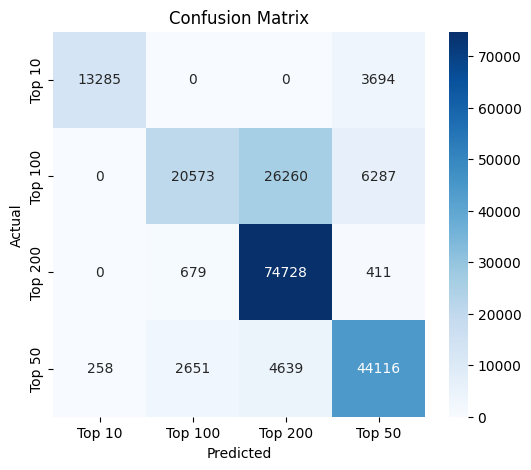

In [28]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

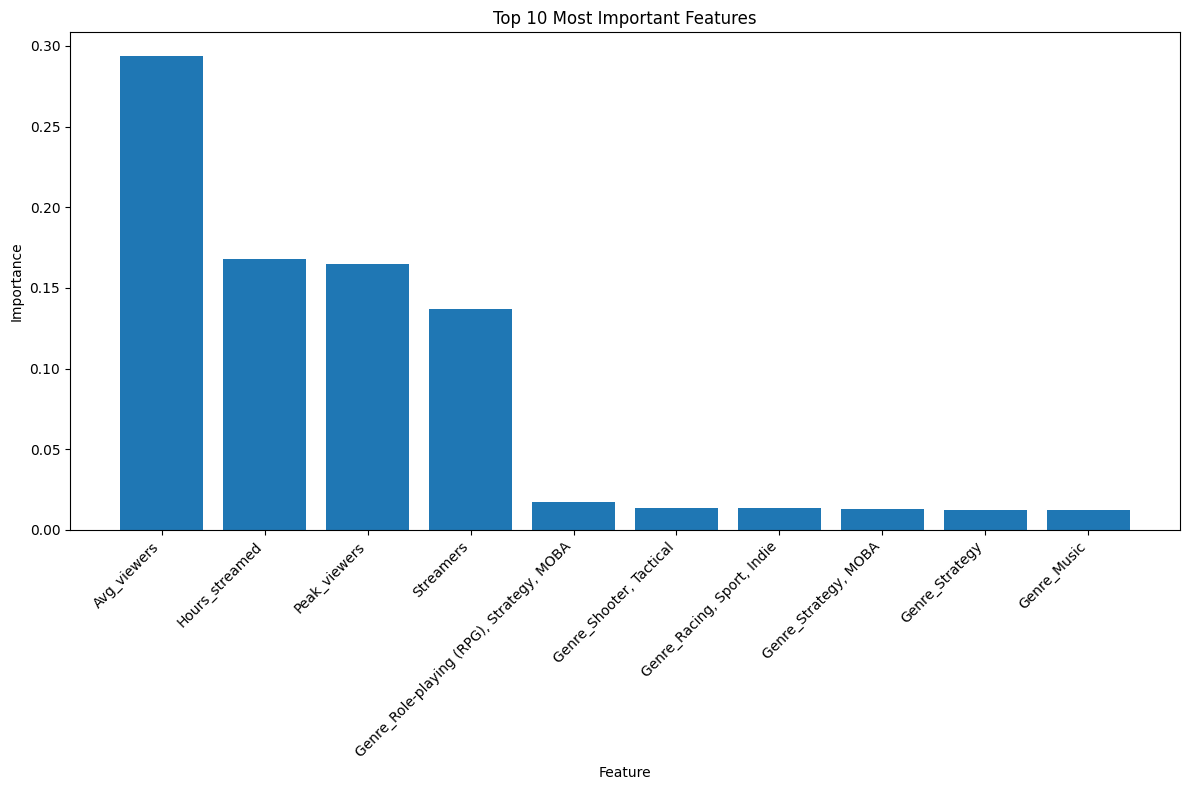

In [15]:
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Top 10 Most Important Features")
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [16]:
# Function to Predict Future Rankings in Categories
def predict_future_rank(year, month):
    X_future = merged_df[(merged_df["Release_Year"] <= year)]
    X_future_games = X_future[["Game"]].copy()
    X_future = X_future.drop(columns=["Rank", "Game"], errors="ignore")

    missing_cols = set(features) - set(X_future.columns)
    for col in missing_cols:
        X_future[col] = 0  # Add missing columns

    X_future = X_future[features]
    predictions = rf_classifier.predict(X_future)

    X_future["Predicted_Category"] = predictions
    X_future["Game"] = X_future_games["Game"].values
    X_future = X_future.sort_values("Predicted_Category").drop_duplicates(subset=["Game"])

    print(f"\n**Top Games Categorized for {year}-{month}**")
    print(X_future[["Game", "Predicted_Category"]].groupby("Predicted_Category").head(10))

predict_future_rank(2025, 6)


**Top Games Categorized for 2025-6**
                                    Game Predicted_Category
0                      League of Legends             Top 10
542755                          Fortnite             Top 10
542862             Call of Duty: Warzone             Top 10
542864                Grand Theft Auto V             Top 10
542540                     Just Chatting             Top 10
542567                          Among Us             Top 10
135825     PLAYERUNKNOWN'S BATTLEGROUNDS             Top 10
135906                       Hearthstone             Top 10
542969  Counter-Strike: Global Offensive             Top 10
543077                         Minecraft             Top 10
580301             ARK: Survival Evolved            Top 100
580286               Super Mario Maker 2            Top 100
580919                            Roblox            Top 100
580396                    Dark Souls III            Top 100
334816                              osu!            Top 100
58

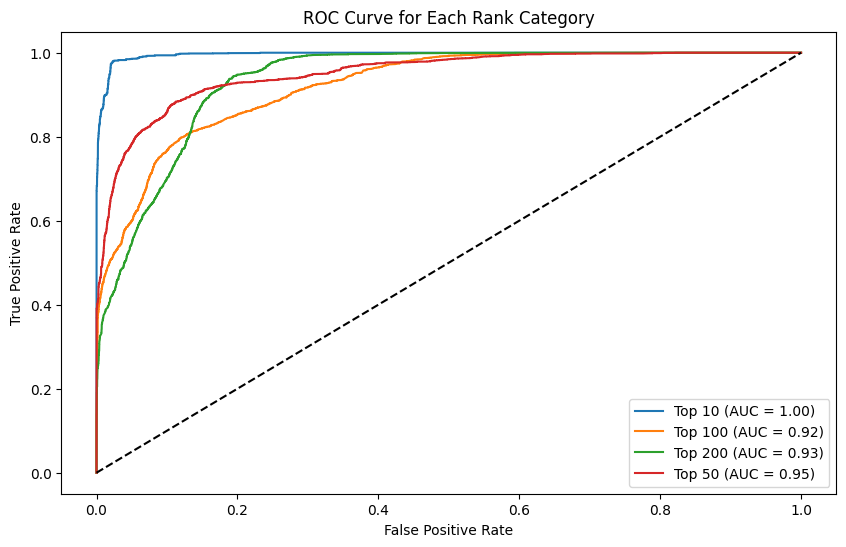

In [18]:
plt.figure(figsize=(10, 6))
for i, label in enumerate(rf_classifier.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Rank Category")
plt.legend()
plt.show()

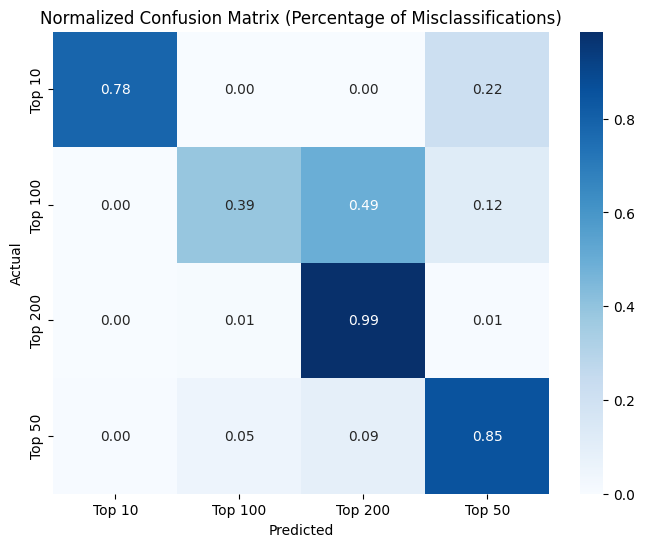

In [27]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix_normalized = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", fmt=".2f",
            xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (Percentage of Misclassifications)")
plt.show()